In [73]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets
from functools import partial
from pathlib import Path
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import string
import torch
import numpy
import graphviz
import utilities

def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

In [74]:
# Define the URL and the local file path where the file will be saved
# Set the base path
file_name = "mnist_sample.tgz"
extract_path = "./mnist_sample"

path = utilities.untar_data(
  'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz', 
  file_name, 
  extract_path
  )
path = (path/'mnist_sample')
Path.BASE_PATH = path

mnist_sample.tgz already exists. Skipping download.
./mnist_sample already exists. Skipping extraction.


In [75]:
threes = sorted((path/'train'/'3').iterdir())
sevens = sorted((path/'train'/'7').iterdir())

seven_tensors = [torch.tensor(numpy.array(Image.open(o))) for o in sevens]
three_tensors = [torch.tensor(numpy.array(Image.open(o))) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

## Stochastic Gradient Descent (SGD)

SGD is a simple yet powerful optimization algorithm used to train machine learning models.


**TLDR**; <br>
 In summary, following is the process of SGD.

1. **Stochastic**: Pick one data point (or a small batch) randomly from the dataset.
2. **Gradient**: Compute the gradient of the loss with respect to each parameter (weights and biases) for that data point.
3. **Learning Rate**: Multiply the gradient by the learning rate ($ \eta $) to control the step size.
4. **Update Parameters**: Adjust the parameters using:
   $$
   \text{New Parameter} = \text{Old Parameter} - \eta \cdot \text{Gradient}.
   $$
5. **Repeat**: Go back to Step 1 and repeat the process for the next data point (or mini-batch).
6. **Convergence**: Continue iterating until the loss stops decreasing significantly or a set number of iterations is reached.

In short: **Stochastic → Gradient → Learning Rate → Update → Repeat → Converge**.

**Easy to understand example:**<br><br>
You’re standing on a hilly landscape, and your goal is to find the lowest point (the valley). Each step you take moves you closer to the bottom.
- The gradient tells you which direction is downhill.
- The learning rate controls how big each step is.

Below we will learn each of these steps in more details. Just if you don't understand what's happening, come back and read the TLDR again.

---

Do you remember the way that Arthur Samuel described machine learning, which we quoted in <<chapter_intro>>?

> : Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
def pr_eight(x,w): return (x*w).sum()
```

Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated in <<gradient_descent>>, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

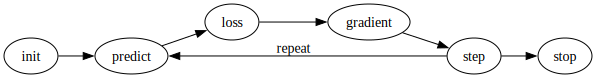

In [76]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

There are many different ways to do each of these seven steps.
These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

### Calculating Gradients

The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the *derivative* of a function tells you how much a change in its parameters will change its result. If not, don't worry, lots of us forget calculus once high school is behind us! But you will have to have some intuitive understanding of what a derivative is before you continue, so if this is all very fuzzy in your head, head over to Khan Academy and complete the [lessons on basic derivatives](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro). You won't have to know how to calculate them yourselves, you just have to know what a derivative is.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

### Stepping With a Learning Rate

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the **learning rate** (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later in this book, called the **learning rate finder**). Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as **stepping** your parameters, using an **optimizer step**. Notice how we _subtract_ the `gradient * lr` from the parameter to update it.  This allows us to adjust the parameter in the direction of the [slope](math.ipynb/#algebra-slope) by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive.  We want to adjust our parameters in the direction of the slope because our goal in deep learning is to _minimize_ the loss.

Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [77]:
def f(x): return (x**2).sum()

xt = torch.tensor([3., 4., 8., 10.]).requires_grad_()
f(xt)

tensor(189., grad_fn=<SumBackward0>)

Time: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])
Speed: tensor([66.3066, 54.2247, 42.2210, 34.2710, 20.5757, 16.5216, 13.8627,  4.8435,
        -2.5848,  3.6991, -1.6452,  2.8018,  5.9687,  4.1017, 18.6041, 27.4000,
        30.5408, 44.0104, 54.6240, 66.6288])


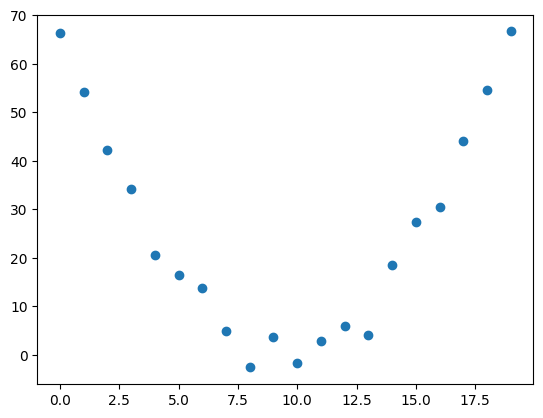

In [78]:
time = torch.arange(0,20).float()
print(f"Time: {time}")
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
print(f"Speed: {speed}")

plt.scatter(time, speed)

In [79]:
# We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) 
# and its parameters (the values that define *which* quadratic we're trying).
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [80]:
# Step1: Initialize a random number
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

In [81]:
# Step2: Calculate the predictions
preds = f(time, params)
print(f"Predictions: {preds}")

Predictions: tensor([  0.7820,   2.1110,   3.9940,   6.4309,   9.4218,  12.9667,  17.0656,
         21.7185,  26.9253,  32.6861,  39.0009,  45.8697,  53.2925,  61.2692,
         69.7999,  78.8846,  88.5233,  98.7159, 109.4625, 120.7631],
       grad_fn=<AddBackward0>)


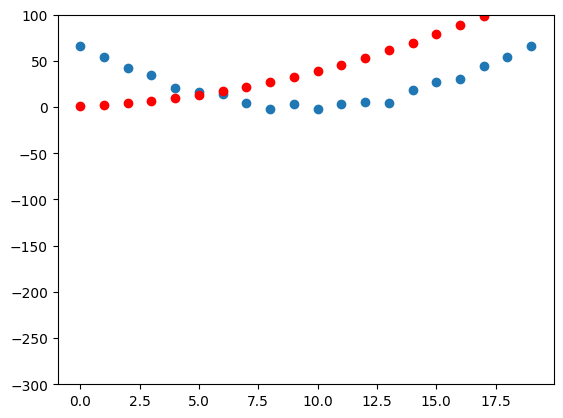

In [82]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    numpy_array = preds.detach().numpy()
    ax.scatter(time, speed)
    ax.scatter(time, numpy_array, color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

In [83]:
# Mean Squared Error
def mse(predictions, actuals): return ((predictions - actuals)**2).mean()

In [84]:
#Step3: Measure the loss
loss = mse(preds, speed)
print(f"MSE Loss: {loss}")

MSE Loss: 1898.379638671875


In [85]:
# Calculate the gradient
loss.backward()

# Step 4: Pick a leaning rate, For now just a small number later we will learn how to pick the right learning rate
params.grad * 1e-5
print(f"Gradient: {params.grad}")
print(f"Updated Parameters: {params}")

Gradient: tensor([11978.9609,   791.3469,    39.2707])
Updated Parameters: tensor([0.2770, 1.0520, 0.7820], requires_grad=True)


In [86]:
# Update the parameters based on the calculated gradient
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [87]:
# Let's see if the loss improved
preds = f(time,params)
print(f"MSE Loss: {mse(preds, speed)}")

MSE Loss: 864.2888793945312


In [88]:
# repeat the process till the loss is minimized
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [89]:
# Iterate by looping many improvements
for i in range(10): apply_step(params)

864.2888793945312
668.6015014648438
631.5659790039062
624.5521240234375
623.2192993164062
622.9615478515625
622.9072265625
622.8914184570312
622.8828735351562
622.8756713867188


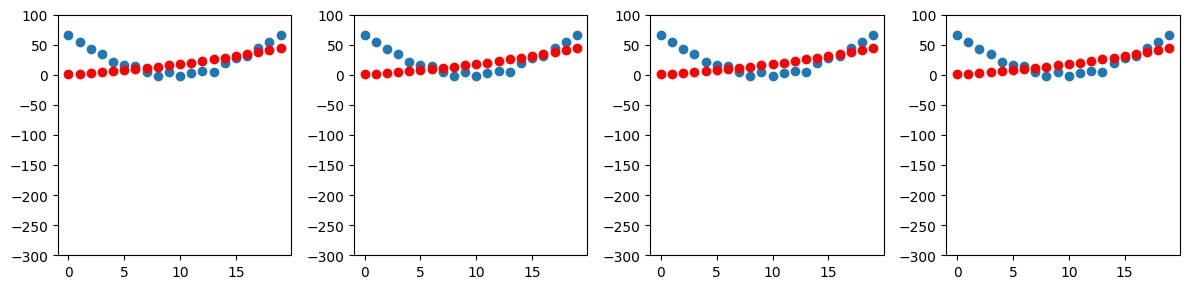

In [90]:
# we plot the function at every step. 
# Then we can see how the shape is approaching the best possible quadratic function for our data:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

To summarize, at the beginning, the weights of our model can be random (training *from scratch*) or come from a pretrained model (*transfer learning*). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to *learn* better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a *loss function*, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the *learning rate* to decide on the step size. We then *iterate* until we have reached the lowest point, which will be our parking lot, then we can *stop*.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective. 

## The MNIST Loss function

### What Are We Trying to Achieve?

We are preparing data for training a machine learning model. Specifically:
1. **Input Data (`train_x`)**: These are the images of handwritten digits (3s and 7s). We need to convert these images into a format the model can understand.
2. **Labels (`train_y`)**: These are the "answers" or categories for each image. For example, we label all images of `3` as `1` and all images of `7` as `0`.

Once the data is prepared, we can use it to train a model that learns to distinguish between `3`s and `7`s.



<a id="preparing_data"></a>
### Step 1: Preparing the Input Data (`train_x`)

#### What Are the Images?
- Each image is a grid of pixels (e.g., 28x28 pixels for MNIST digits).
- In PyTorch, these images are stored as tensors (multi-dimensional arrays).

#### Why Change the Shape?
- A single image is a **matrix** (rank-2 tensor) of size `(28, 28)` (height x width).
- To feed these images into most machine learning models, we need to "flatten" them into **vectors** (rank-1 tensors) of size `(784,)` (since $ 28 \times 28 = 784 $).

#### How Do We Flatten Them?
- We use the `.view(-1, 28*28)` method:
  - `-1`: Automatically calculates how many rows are needed based on the data.
  - `28*28`: Flattens each image into a vector of length 784.

#### Combining All Images
- We have two groups of images: `stacked_threes` (all images of `3`) and `stacked_sevens` (all images of `7`).
- We combine them into one big tensor using `torch.cat()`.

#### Final Result:


In [144]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x[:1]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

- This creates a single tensor where:
  - Each **row** represents one flattened image (a vector of 784 pixels).
  - The total number of rows is the total number of images (`len(threes) + len(sevens)`).

### Step 2: Creating Labels (`train_y`)

#### What Are Labels?
- Labels tell the model what each image represents:
  - `1` means the image is a `3`.
  - `0` means the image is a `7`.

#### How Do We Create Labels?
- For all `3`s, we create a list of `1`s with the same length as the number of `3`s.
- For all `7`s, we create a list of `0`s with the same length as the number of `7`s.
- We concatenate these lists into one.

#### Adding an Extra Dimension
- Machine learning models often expect labels to be in a specific shape, like a column vector (rank-2 tensor with shape `(n, 1)`).
- We use `.unsqueeze(1)` to add an extra dimension to the labels tensor.

#### Final Result:

In [92]:
train_y = torch.tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)


- This creates a tensor where:
  - Each row corresponds to the label of one image.
  - The shape is `(n, 1)`, where `n` is the total number of images.

<a id="preparing_data_step_3"></a>
### Step 3: Prepare the data for PyTorch


A [Dataset](optional_read.ipynb/#pytorch-dataset) in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [93]:
dataset = list(zip(train_x,train_y))
x,y = dataset[0]

x.shape,y

(torch.Size([784]), tensor([1]))

Also we need to prepare our validation sets the same way as training set.

In [94]:
valid_3_files = (path/'valid'/'3').iterdir()
valid_3_tens = torch.stack([torch.tensor(numpy.array(Image.open(o))) for o in valid_3_files])
valid_3_tens = valid_3_tens.float() / 255

# Load and process validation images for '7'
valid_7_files = (path/'valid'/'7').iterdir()
valid_7_tens = torch.stack([torch.tensor(numpy.array(Image.open(o))) for o in valid_7_files])
valid_7_tens = valid_7_tens.float() / 255

In [95]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = torch.tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Our dataset is now prepared for training, let's dive into the actual training steps.
As you may recall: 

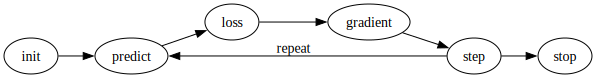

In [96]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

---

# Start the training process

We'll be using **Logistic Regression** (a classification model). The purpose is to train the model to distinguish between two classes (3s and 7s) by learning a decision boundary using weights and bias. 

In a linear model, the prediction is calculated as: $y=w⋅x+b$

In neural networks, the `w` in the equation $y=w*x+b$ is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

## 1. Init

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

In [97]:
# initialize random weights for a model and prepares them for training:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

> We’re creating initial weights for a model, scaled appropriately, and ensuring they’re ready for gradient-based optimization.<br><br> 1. **`torch.randn(size)`**: Creates random numbers from a normal distribution (mean = 0, std = 1) with the given shape (`size`).<br>2. **`* std`**: Scales the random numbers to control their range (e.g., smaller `std` makes weights closer to 0).<br>3. **`.requires_grad_()`**: Tells PyTorch to track these weights so their gradients can be calculated during training.<br>

>**What Is std?** <br>
In short, std is to adjust the initial scale of the weights by making them larger or smaller at the start of training. This helps ensure the weights are in a good range for effective learning, but it doesn’t directly depend on the loss function.<br><br>
std stands for standard deviation , which controls the spread or scale of the random numbers. <br><br>
By multiplying the random numbers by std, we adjust their range. For example: <br><br>
If std = 1.0, the random numbers stay as-is (standard normal distribution). <br>
If std = 0.01, the random numbers are scaled down to be much smaller.

We create weights with size (28*28, 1) because:
- Each image is flattened into a vector of 784 pixels (features),
- We need one weight for each pixel to compute a weighted sum,
- The model produces a single output (e.g., a prediction for binary classification).

In [98]:
weights = init_params((28*28,1))
weights[:5]

tensor([[ 0.4702],
        [ 2.1746],
        [-0.3294],
        [-1.3069],
        [-1.7004]], grad_fn=<SliceBackward0>)

The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

This bias adds flexibility to the model by allowing it to shift predictions up or down, ensuring it can fit data even when inputs are zero. Like weights, the bias is updated during training to minimize the loss.

In [99]:
bias = init_params(1)
bias

tensor([1.5504], requires_grad=True)

## 2. Predict

We can now calculate a prediction for one image:

In [100]:
one_image = train_x[0]
weights_transpose = weights.T

one_image_predication = (one_image * weights_transpose).sum() + bias
one_image_predication

tensor([14.5449], grad_fn=<AddBackward0>)

The `T` in `weights.T` stands for **transpose**. It’s a mathematical operation that flips the dimensions of a tensor or matrix.

> You can read more details about `.T` and how it works in Optional read notebook [.T Pytorch Transpose In Details](optional_read.ipynb#pytorch-transpose)

> If you are having hard time understanding what just happened here, read the simpler illustration in Optional reads Notebook [SGD Illustrate with code](optional_read.ipynb#sgd-illustrate-with-code)

Above example was just for one image in our dataset, now how do we do this for all the images to get prediction score? You might be thinking, we will loop through all the dataset and apply the function.
We could! However, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix—it's called *matrix multiplication*.

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

In [101]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[14.5449],
        [11.3809],
        [15.4577],
        ...,
        [ 1.7349],
        [16.5985],
        [ 5.3557]], grad_fn=<AddBackward0>)

> More details about this operation which is a __Linear Transformation and Matrix Multiplication__,  can be find [Linear Transformation: Matrix Multiplication](optional_read.ipynb#linear-transformation-matrix-multiplication)

The first element is the same as we calculated before, as we'd expect. This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the *activation function*, which we'll see in a moment).

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [102]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [103]:
corrects.float().mean().item()

0.5209745168685913

> `.item()` extracts the value from the tensor as a plain Python number (e.g., `0.75` instead of `tensor(0.75)`).


Now let's see what the change in accuracy is for a small change in one of the weights (note that we have to ask PyTorch not to calculate gradients as we do this, which is what `with torch.no_grad()` is doing here):
If you try to modify `weights[0]` without `torch.no_grad()`, PyTorch will raise an error because it tries to track the operation for gradient computation
When gradient tracking is disabled, any operations performed inside the with `torch.no_grad():` block will not:
- Compute gradients,
- Update the computation graph (which tracks how outputs depend on inputs).

In [104]:
# This code updates one of the weights in the model without tracking gradients.
with torch.no_grad(): weights[0] *= 1.0001

> `with` syntax is same as following:
>```python
>try:
    >torch.no_grad().__enter__()  # Disable gradient tracking
   >weights[0] *= 1.0001         # Slightly increase the first weight
>except Exception as e:
    >print(f"An error occurred: {e}")
>finally:
    >torch.no_grad().__exit__(None, None, None)  # Re-enable gradient tracking

In [105]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5209745168685913

This demonstrates that:
- A single small tweak to one weight isn’t enough to significantly improve the model.
- To train the model effectively, we need to update all the weights simultaneously using gradients calculated from the loss function.
- This is why we rely on Stochastic Gradient Descent (SGD) or similar optimization algorithms—they compute gradients for all weights and adjust them in a coordinated way to minimize the loss.

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some *loss function* that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.

> S: In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Let's write such a function now. What form does it take?


## 3. Loss


The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (`0.9`) that the first was a 3, with slight confidence (`0.4`) that the second was a 7, and with fair confidence (`0.2`), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [106]:
trgts  = torch.tensor([1,0,1])
prds   = torch.tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

In [107]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

> note: Read the Docs: It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running `help(torch.where)` now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

>__Why Use `1 - prds`?__<br>
>When the true label is 1 (the image is a 3), we want the model to predict a value close to 1.
>If the prediction (prds) is far from 1, the loss should be high.
>
>Suppose the true label is 1 and the predictions are:
>- Prediction = `0.9`: `1 - 0.9 = 0.1` (small penalty, good prediction).
>- Prediction = `0.2`: `1 - 0.2 = 0.8` (large penalty, bad prediction).
>
>This ensures that predictions closer to 1 are rewarded, while predictions far from 1 are penalized.

Let's try it on our `prds` and `trgts`:

In [108]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. In PyTorch, we always assume that a lower value of a loss function is better. Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:

In [109]:
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for the one "false" target from `0.2` to `0.8` the loss will go down, indicating that this is a better prediction:

In [110]:
mnist_loss(torch.tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

### Sigmoid

Sigmoid is one type of [activation functions](00_what_is_what.ipynb#activation-function).
The [sigmoid](math.ipynb/#sigmoid-function) function always outputs a number between 0 and 1. It's defined as follows:

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

<img id="sigmoid" src="images/sigmoid.png"/>

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 

Let's update `mnist_loss` to first apply `sigmoid` to the inputs and apply Binary Cross-Entropy (BCE) loss function.

In [111]:
# Binary Cross-Entropy (BCE) loss is a common loss function used for binary classification problems
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence an image is a 3.

Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

## 4. Gradient

### SGD and Mini-Batches

Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an *optimization step*.

In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, you'd be going to the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.

So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a *mini-batch*. The number of data items in the mini-batch is called the *batch size*. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this book.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!

As we saw in our discussion of data augmentation in <<chapter_production>>, we get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.

<a id="data-loader"></a>
A `DataLoader` can take any Python collection and turn it into an iterator over mini-batches, like so:

In [112]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([14,  9, 12,  3,  6]),
 tensor([11,  8, 13,  7, 10]),
 tensor([1, 4, 0, 5, 2])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`. Here's an example of an extremely simple `Dataset`:

In [113]:
ds = list(enumerate(string.ascii_lowercase))
ds[:4]

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd')]

When we pass a `Dataset` to a `DataLoader` we will get back mini-batches which are themselves tuples of tensors representing batches of independent and dependent variables:

In [114]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[[tensor([22,  8,  2, 24, 17,  0]), ('w', 'i', 'c', 'y', 'r', 'a')],
 [tensor([10, 11,  6,  1, 20,  7]), ('k', 'l', 'g', 'b', 'u', 'h')],
 [tensor([ 3, 14,  9, 15, 16, 23]), ('d', 'o', 'j', 'p', 'q', 'x')],
 [tensor([ 4, 13, 25,  5, 12, 18]), ('e', 'n', 'z', 'f', 'm', 's')],
 [tensor([19, 21]), ('t', 'v')]]

We are now ready to write our first training loop for a model using SGD!

## Putting It All Together

Training is the process of improving the prediction function by adjusting the weights and bias.

Here’s how it works in our case:

### Choose a model:

Select the type of model to use for the problem.
This could be a _linear model_, _decision tree_, _neural network_, or any other algorithm.
The choice depends on the problem type (e.g., regression, classification), data characteristics, and computational constraints.
For our case a **linear model** fits perfectly.

### Make Predictions (linear model)

$Prediction=(Input⋅Weights)+Bias$
- Use the current weights and bias to compute predictions for the inputs.
- This is where the prediction function comes into play.

### Calculate Loss
- Compare the predictions to the true labels using a loss function.
- The loss measures how "wrong" the predictions are.

### Adjust Weights and Bias
- Use an optimization algorithm (like SGD) to update the weights and bias in a way that reduces the loss.
- This involves computing gradients (derivatives of the loss with respect to the weights and bias) and applying small updates.

<img alt="ML Process" width="400" caption="ML Process" src="images/ml_process.png" id="matmul"/>

It's time to implement the process we saw in <<gradient_descent>>. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

First, let's re-initialize our parameters:

In [115]:
weights = init_params((28*28,1))
bias = init_params(1)

### [Prepare the data](#preparing_data)

Prepare Training and Validation sets.

In [116]:
# Data stacked
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
# Labels
train_y = torch.tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

# For test test we do the same
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = torch.tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

Make it [PyTorch ready](#preparing_data_step_3).

In [117]:
# A Dataset in PyTorch is required to return a tuple of `(x,y)` when indexed.
# We create a tuple from our x and y.
train_dataset = list(zip(train_x,train_y))
valid_dataset = list(zip(valid_x,valid_y))

Convert it to PyTorch [DataLoader](#data-loader) for batch-sizing and shuffleing.

In [118]:

# For shuffling and mini-batch collation we need to create a DataLoader from our DataSets.
# A DataLoader can take any Python collection and turn it into an iterator over mini-batches, like so:
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
test_dataloadet = DataLoader(valid_dataset, batch_size=256, shuffle=True)
# iter(dl) function is a built-in Python function. It creates an iterator from the DataLoader (dl), which allows you to retrieve batches of data.
# The next function is a built-in Python function. It retrieves the next item from an iterator.
train_features, train_labels = next(iter(dl))

### 1- Init

In [119]:
# Cweights with size (28*28, 1) because:
# - Each image is flattened into a vector of 784 pixels (features),
# - We need one weight for each pixel to compute a weighted sum,
# - The model produces a single output (e.g., a prediction for binary classification).#
weights = init_params((28*28, 1))

# This bias adds flexibility to the model by allowing it to shift predictions up or down, 
# ensuring it can fit data even when inputs are zero. 
# Like weights, the bias is updated during training to minimize the loss.
bias = init_params(1)

### 2- Predict
We chose a simple [linear model](optional_read.ipynb#linear-model) for this prediction.

In [120]:
def linear_r1_model_predict(xb): return xb@weights + bias

Let's test it with a mini batch.

In [121]:
mini_batch = train_x[:5]
mini_batch_prediction = linear_r1_model_predict(mini_batch)

### 3- Measure the loss

Measure the loss using [Binary Cross-Entropy](optional_read.ipynb#binary-cross-entropy) function:

In [122]:
loss = mnist_loss(mini_batch_prediction, train_y[:5])
loss

tensor(0.2375, grad_fn=<MeanBackward0>)

### 4- Calculate the gradient

We can create a function to automate the task of calculating gradient for each input data.

In [123]:
def predict_and_calculate_gradient(input_batch, label_batch, model):
    # Step 1: Make predictions using the model
    predictions = model(input_batch)
    # Step 2: Compute the loss by comparing predictions to true labels
    loss = mnist_loss(predictions, label_batch)
    # Step 3: Compute gradients of the loss with respect to the model's parameters
    loss.backward()


And test it:

In [124]:

predict_and_calculate_gradient(mini_batch, train_y[:5], linear_r1_model_predict)
# Current gradients
weights.grad.shape,weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0050), tensor([-0.0316]))

If we calculate the gradient again the value of our gradients will differ from the first time. The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [125]:
predict_and_calculate_gradient(mini_batch, train_y[:5], linear_r1_model_predict)
# Current gradients
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0099), tensor([-0.0631]))

In [126]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

### 5- Optimize and Repeat

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [127]:
def train_epoch(dataset, ml_model, learning_rate, params):
    # Loop through each batch of inputs and labels in the dataset
    for input, label in dataset:
        # Step 1: Compute predictions and calculate gradients
        predict_and_calculate_gradient(input, label, ml_model)
        
        # Step 2: Update each parameter (weight/bias) based on the gradient
        for param in params:
            # Update the parameter using the gradient and learning rate
            # New Parameter=Old Parameter−(Gradient×Learning Rate)
            param.data -= param.grad * learning_rate
            
            # Reset the gradient to zero for the next batch
            param.grad.zero_()

### What Is `p.data`?
- `p` is a parameter tensor (e.g., weights or biases) in your model.
- `p.data` refers to the actual numerical values stored in the tensor, without any gradient-tracking behavior.

- For example, if p represents a weight tensor, `p.data` contains the current values of the weights.

When you modify p.data, you are directly changing the values of the weights or biases without telling PyTorch to track this change in the computation graph. This is important because we don’t want PyTorch to compute gradients for this update step itself—it would complicate things when computing gradients for the next batch.

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [128]:
(mini_batch_prediction>0.0).float() == train_y[:5]

tensor([[ True],
        [False],
        [ True],
        [ True],
        [ True]])

That gives us this function to calculate our validation accuracy:

In [129]:
def batch_accuracy(input, label):
    predictions_sigmoid = input.sigmoid()
    correct = (predictions_sigmoid>0.5) == label
    return correct.float().mean()

We can check it works:

In [130]:
batch_accuracy(linear_r1_model_predict(mini_batch), train_y[:5])

tensor(0.8000)

and then put the batches together:

In [131]:
def validate_epoch(model):
    accs = [batch_accuracy(model(input), label) for input,label in test_dataloadet]
    return round(torch.stack(accs).mean().item(), 4)

In [132]:
validate_epoch(linear_r1_model_predict)

0.5648

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [133]:
lr = 1.
params = weights,bias
train_epoch(train_dataset, linear_r1_model_predict, lr, params)
validate_epoch(linear_r1_model_predict)

0.5098

The do a few more.

In [134]:
for i in range(20):
    train_epoch(train_dataset, linear_r1_model_predict, lr, params)
    print(validate_epoch(linear_r1_model_predict), end=' ')

0.5855 0.7546 0.786 0.7955 0.7925 0.8185 0.8738 0.8973 0.8852 0.899 0.9098 0.8984 0.9058 0.9103 0.9327 0.921 0.9053 0.9156 0.9245 0.9368 

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

### Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [135]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [136]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [137]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

In [138]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [139]:
def train_epoch(dataset, model):
    for xb, yb in dataset:
        predict_and_calculate_gradient(xb, yb, model)
        opt.step()
        opt.zero_grad()

Let's put our little training loop in a function, to make things simpler:

In [142]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(train_dataset, model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [143]:
train_model(linear_model, 20)

0.5044 0.525 0.7022 0.6429 0.6363 0.7901 0.7907 0.8336 0.8394 0.8647 0.8728 0.8268 0.8636 0.8457 0.8469 0.87 0.8755 0.8984 0.8929 0.9186 

## Adding a Nonlinearity

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

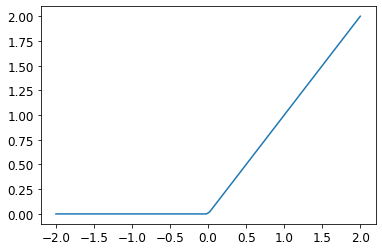

In [ ]:
plot_function(F.relu)

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

> S: Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the [Universal Approximation Theorem](00_what_is_what.ipynb#uni_apprx_theo). The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

### Going Deeper

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

# Illustrate Psudo example
We’ll use the first tensor from your dataset (`train_x[:1]`) and manually compute everything.



### **Setup**

We’ll assume:
1. The input tensor is `x = train_x[:1]` (a flattened image with 784 pixel values).
2. The model has one weight vector `w` of size `(784,)` and one bias `b`.
3. The learning rate is `lr = 0.01`.
4. The loss function is **Binary Cross-Entropy (BCE)**, which we’ll compute manually.

Let’s initialize the parameters randomly:


In [ ]:
# Input tensor (flattened image)
x = train_x[:1]  # Shape: (1, 784)

# Randomly initialize weights and bias
numpy.random.seed(42)  # For reproducibility
w = numpy.random.randn(784)  # Shape: (784,)
b = numpy.random.randn()     # Scalar

# Learning rate
lr = 0.01

# True label (e.g., 1 for digit '3', 0 for digit '7')
y_true = 1.0



### **Step-by-Step Demonstration**

#### **Step 1: Compute the Prediction**
The prediction is computed as:
$$
\text{logit} = w \cdot x + b
$$
Then, apply the sigmoid function to get the probability:
$$
\text{prediction} = \sigma(\text{logit}) = \frac{1}{1 + e^{-\text{logit}}}
$$

Here’s the manual computation:



In [ ]:

# Compute logit (weighted sum + bias)
logit = numpy.dot(x, w) + b  # Shape: (1,)

# Apply sigmoid
def sigmoid(z):
    return 1 / (1 + numpy.exp(-z))

prediction = sigmoid(logit)  # Probability between 0 and 1
print(f"Prediction: {prediction}")



For example:
- If `logit = 2.0`, then `sigmoid(2.0) ≈ 0.88`.

#### **Step 2: Compute the Loss**
The loss is computed using **Binary Cross-Entropy (BCE)**:
$$
\text{Loss} = - \big( y_{\text{true}} \cdot \log(\text{prediction}) + (1 - y_{\text{true}}) \cdot \log(1 - \text{prediction}) \big)
$$

Here’s the manual computation:



In [ ]:

# Compute BCE loss
def binary_cross_entropy(prediction, y_true):
    return - (y_true * np.log(prediction) + (1 - y_true) * np.log(1 - prediction))

loss = binary_cross_entropy(prediction, y_true)
print(f"Loss: {loss}")




For example:
- If `prediction = 0.88` and `y_true = 1.0`, then:
  $$
  \text{Loss} = - \big( 1.0 \cdot \log(0.88) + (1 - 1.0) \cdot \log(1 - 0.88) \big) \approx 0.127
  $$

#### **Step 3: Compute Gradients**
To update the parameters, we need the gradients of the loss with respect to `w` and `b`. Using calculus:
1. Gradient of loss with respect to `logit`:
   $$
   \frac{\partial \text{Loss}}{\partial \text{logit}} = \text{prediction} - y_{\text{true}}
   $$
2. Gradient of `logit` with respect to `w`:
   $$
   \frac{\partial \text{logit}}{\partial w} = x
   $$
3. Gradient of `logit` with respect to `b`:
   $$
   \frac{\partial \text{logit}}{\partial b} = 1
   $$

Combine these to get the gradients:
$$
\frac{\partial \text{Loss}}{\partial w} = (\text{prediction} - y_{\text{true}}) \cdot x
$$
$$
\frac{\partial \text{Loss}}{\partial b} = \text{prediction} - y_{\text{true}}
$$

Here’s the manual computation:



In [ ]:

# Compute gradient of loss with respect to logit
grad_logit = prediction - y_true

# Compute gradients of loss with respect to w and b
grad_w = grad_logit * x.flatten()  # Shape: (784,)
grad_b = grad_logit                # Scalar

print(f"Gradient of w: {grad_w}")
print(f"Gradient of b: {grad_b}")




For example:
- If `prediction = 0.88` and `y_true = 1.0`, then:
  $$
  \text{grad\_logit} = 0.88 - 1.0 = -0.12
  $$
  $$
  \text{grad\_w} = -0.12 \cdot x
  $$
  $$
  \text{grad\_b} = -0.12
  $$

#### **Step 4: Update Parameters**
Update the parameters using the gradients and learning rate:
$$
w = w - \text{lr} \cdot \text{grad\_w}
$$
$$
b = b - \text{lr} \cdot \text{grad\_b}
$$

Here’s the manual computation:



In [ ]:

# Update weights and bias
w = w - lr * grad_w
b = b - lr * grad_b

print(f"Updated w: {w}")
print(f"Updated b: {b}")




For example:
- If `grad_w = [-0.12, -0.12, ...]` and `grad_b = -0.12`, then:
  $$
  w = w - 0.01 \cdot [-0.12, -0.12, ...]
  $$
  $$
  b = b - 0.01 \cdot (-0.12)
  $$